In [ ]:
from google.colab import files
uploaded = files.upload()

Saving squares_15.tiff to squares_15.tiff
Saving squares_16.tiff to squares_16.tiff


In [1]:
pip install qiskit

     |████████████████████████████████| 6.5 MB 4.8 MB/s 
     |████████████████████████████████| 18.0 MB 8.7 MB/s 
     |████████████████████████████████| 238 kB 46.9 MB/s 
     |████████████████████████████████| 200 kB 44.9 MB/s 
     |████████████████████████████████| 54 kB 2.2 MB/s 
     |████████████████████████████████| 1.6 MB 40.6 MB/s 
     |████████████████████████████████| 38.1 MB 12.5 MB/s 
     |████████████████████████████████| 49 kB 3.2 MB/s 
     |████████████████████████████████| 943 kB 46.3 MB/s 
     |████████████████████████████████| 37.5 MB 6.0 MB/s 
     |████████████████████████████████| 49 kB 4.2 MB/s 
     |████████████████████████████████| 3.6 MB 39.0 MB/s 
     |████████████████████████████████| 113 kB 48.4 MB/s 
  Created wheel for qiskit: filename=qiskit-0.34.2-py3-none-any.whl size=11805 sha256=2936cf2592b396a209ab54ab63f26ec0d277a4da75c12a8a8451334f81a42dc2
  Stored in directory: /root/.cache/pip/wheels/62/77/65/cda6eedfdd2a525bd3f479a4386930ae3088a1eb01f8c

In [2]:
# Import general libraries
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
from numpy import pi
from PIL import Image
from scipy.sparse import coo_matrix
from scipy.optimize import minimize
from sklearn.feature_extraction import image

# importing qiskit libraries 
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, assemble, execute, BasicAer, ClassicalRegister, QuantumRegister
from qiskit.quantum_info.operators import Operator
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.visualization import plot_histogram
from qiskit.circuit import Gate, Parameter
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.basicaer import QasmSimulatorPy
from qiskit.compiler import transpile
from qiskit.quantum_info.operators import Operator, Pauli
from qiskit.circuit.library.standard_gates import RYGate

# General Use Functions

In [ ]:
# Get the list of images
def get_list_of_images():
  """ The dataset is composed by 28 images
  - 4 images created with randomly generated numbers
  - 4 images with the pixels of the leftmost column ranging over 0-50, the other pixels ranging around 100-255
  - 4 images with the pixels of the 2 leftmost columns ranging over 0-50, the other 2 columns with pixels ranging around 100-255 
  - 4 images with the pixels of the leftmost column ranging over 0-30, the second leftmost column with 
  pixels ranging 70-120, and the other pixels ranging around 180-255
  - 4 images with the pixels of the 2 leftmost columns ranging over 0-30, the second rightmost column with 
  pixels ranging 70-120, and the other ranging around 180-255
  - 4 images with randomly positioned 4 squares of 2x2 pixels ranging around 0-63, 64-127, 128-191, and 192-255.


  The name after each image is composed as:
    - squares + #number# + .tiff

  Output:
    - list_images: list, the list for the 28 images
  """
  list_images = []
  for i in range(1,29):
    list_images.append('squares_'+str(i)+'.tiff')
  return list_images


# Open all the images opened in this colaboratory
def open_image(file_name):
  """
  Function to obtain the image converted into an array

  Input: 
    - file_name: string, an image (.tiff in this case) of p columns and q rows

  Output: 
    - image_array: array, 2D array of p*q elements
  """
  imag = Image.open(file_name) 
  image_array = np.asarray(imag) # convert the image into an array
  return image_array


# get the number of qubits for the Quantum pixel Distance Estimation
def number_of_qubits(flatten_img):
  """
  Obtain the number of Qubits for the Quantum Pixel Distance Estimation

  Input: 
    - flatten_img: array, image converted into an 1D array
  
  Output: 
    - qubits: int, the number of qubits needed for the QPDE
  """
  qubits = np.log2(flatten_img.shape[0])+1 # get the log base 2 of a number + 1 extra qubit
  return qubits.astype(int)


# Compute the edges
def compute_edges(adjacency_matrix):
  """
  Function to compute the edges of a graph representation (adjacency matrix)

  Input: 
    - adjacency_matrix: array, 2D array of (pq)*(pq) positions from a p cols and q rows image

  Output: 
    - edges: list, egdes list of the form [(node_1, node_2),...,(node_n, node_n-1)]
             whenever node_n and node_m are neighbors
  """
  edges = [] # Initialize the list
  for row in range(adjacency_matrix.shape[0]):
    for col in range(adjacency_matrix.shape[1]): # for every column and row, do
      if adjacency_matrix[row, col]!=0 and row!=col: # Except when the values of the adj matrix are 0
        edges.append((row, col)) # Append the value of the column and row
  return edges


# Compute the unweighted adjacency matrix and the edges
def compute_adj_matrix_and_edges(image_array):
  """
  Function to compute the unweighted adjacency matrix and the edges
  
  Input: 
    - image_array: 2D array of ints, p*q image converted into a p*q array 

  Output: 
    - unweighted_adj_mat: 2D array of 1's and 0s, (pq)*(pq) unweighted adjacency array
    - edges: list, egdes list of the form [(node_1, node_2),...,(node_n, node_n-1)]
             whenever node_n and node_m are neighbors
  """
  # Initialize the graph with the 4-neighbor graph
  graph = image.img_to_graph(image_array.astype(float))
  
  unweighted_adj_mat = np.zeros(graph.toarray().shape).astype(float)

  # Convert the data into 1 to rpresent the weight 1 of each node
  for row in  range(graph.toarray().shape[0]):
    for col in range(graph.toarray().shape[1]):
      if row != col and graph.toarray()[row,col] != 0:
        unweighted_adj_mat[row, col] = 1.0

  # Compute the edges of the adjacency matrix
  edges = compute_edges(unweighted_adj_mat)
  return unweighted_adj_mat, edges


# Plot the segmentation results
def plot_segmentation_results(image_array, segmentation):
  """
  Function to plot the image with the corresponding segmentation

  Input: 
    - image_array: 2D array of ints, p*q image converted into a p*q array 
    - segmentation: list or 1D array

  Output: 
    - plot the segmentation
  """
  fig, axs = plt.subplots(1,2, figsize = (7,7), constrained_layout=True, sharey=True)
  # show the clusters 
  axs[0].matshow(image_array, cmap=plt.get_cmap('gray'))
  axs[1].matshow(segmentation.reshape(image_array.shape), cmap=plt.get_cmap('gray'))
  axs[0].set_title('Original Image', ha="center", va="center", color="k", fontsize=20, fontweight = 'medium')
  axs[1].set_title('Image Segmented', ha="center", va="center", color="k", fontsize=20, fontweight = 'medium')
  for i in range(2):
    axs[i].set_xticks(np.arange(-0.5,4.5))
    axs[i].set_yticks(np.arange(-0.5,4.5))
    axs[i].set_xticklabels([])
    axs[i].set_yticklabels([])
  plt.show()

In [5]:
# Create the graph associated with the adjacency matrix
def create_network(adjacency_matrix, edges):
  """
  Function to create a graph/network from an adjacency matrix and the list of edges

  Input: 
    - adjacency_matrix: array, 2D array of (pq)*(pq) positions from a p cols and q rows image
    - edges: list, egdes list of the form [(node_1, node_2),...,(node_n, node_n-1)]
             whenever node_n and node_m are neighbors

  Output: 
    - working_graph: nx graph
    - number_of_pixels: int, information about how many pixels the image has
  """
  # Identify working pixels
  number_of_pixels = adjacency_matrix.shape[0]

  # Populate a networkx graph with pixels as nodes.
  working_graph = nx.Graph()
  for node in range(number_of_pixels):
      working_graph.add_node(node)

  # Pair up all neighbors with random weights in working_graph.
  for pixel in edges:
      working_graph.add_edge(pixel[0], pixel[1], weight=adjacency_matrix[pixel[0], pixel[1]])

  return working_graph, number_of_pixels


# Compute the size of the cut
def compute_cut_size(labels, graph):
  """
  Function to compute the cut size of a graph given a segmentation list

  Input: 
    - labels: list or 1D array, list of labels/segment
    - graph: nx graph

  Output: 
    - cut_size: int, a number corresponding to the normalized cut size
  """
  A_partition, B_partition = compute_partition_segments(labels, graph)
  cut_size = nx.normalized_cut_size(graph, A_partition, B_partition, weight='weight')
  return cut_size



def compute_partition_segments(labels, graph):
  """
  Given the segmentation in a list and the working graph, thid function computes 
  the list of the 2 subclasses

  Input:
    - labels: list or numpy array, it has the following form [0,1,0,1], where 
              0 belongs to subclass A, and 1 to B
    - graph: nx graph

  Output:
    - A_partition: set, information about which nodes belong to segment A
    - A_partition: set, information about which nodes belong to segment B
  """
  df = pd.Series(labels) # initialize a dataframe with the segment/labels array
  one_qubits = set(df[df==1].index) 
  A_partition = set()
  B_partition = set()

  for node in graph:
      if node in one_qubits:
          # If a one was measured add node to S partition.
          A_partition.add(node)
      else:
          # Otherwise a zero was measured so add to T partition.
          B_partition.add(node)
  return A_partition, B_partition



# This lambda function works to give the n bitstring for all the 2^n states
def get_binary_number(x, n):
  """
  Function to obtain the binary representation of a given number with n positions

  Input: 
    - x: int, the number to convert
    - n: int, the number of positions to fill in, if the binary number is less than the positions,
            it fills with 0s

  Output: 
    - string, string of n positions corresponding to the binary number
  """
  return format(x, 'b').zfill(n)



def get_binary_segment(x, n):
  """
  Function to obtain the binary representation of a given number with n positions

  Input: 
    - x: int, the number to convert
    - n: int, the number of positions to fill in, if the binary number is less than the positions,
            it fills with 0s

  Output: 
    - list, list with n positions corresponding to the binary number
  """
  segment = []
  # for every element in the string, append it to the list
  for bit in get_binary_number(x,n):
    segment.append(int(bit))
  return segment



def compute_average_std_of_cuts(list_of_results):
  """
  Compute the average and the standard deviation of a list of results

  Input: 
    - list_of_results: list, experiment/algorithm results 

  Output:
    - average: float, the average of the results given in a list
    - std_dev: standard deviation of the results given in a list
  """
  array_of_results = np.array(list_of_results)
  average = np.around(array_of_results.mean(),6)
  std_dev = np.around(array_of_results.std(),6)
  return average, std_dev

# Functions to builld QPDE

In [ ]:
def quantum_QPDE_circuit(circuit, qubits, image_array, row):
  """
  Quantum circuit to compute the Quantum Pixel Distance Estimation. Estimates the 
  distance between the intensity value of pixel u and the the rest of the pixels 
  form an image. 

  Input:
    - circuit: qiskit circuit
    - qubits: int, number of qubits needed in the circuit
    - immage_array: numpy array, a 1D array with p*q elements from a 
                    (p rows)*(q columns) picture
    - row: int, the number of row wee are working with 

  Output:
    - circuit: qiskit circuit, the QPDE circuit
  """
  circuit.h(np.arange(qubits-1))

  for col in range(image_array.shape[0]):
      control_state = get_binary_number(col,4)
      # Let us create the RYj (columns) and RYi (rows) gates. Note that we are using 
      # already controlled states for RYi and RYj when we defined the circuit QPDE
      # with the controlled gate (RYj*RYi). It is the same
      RYj = Operator(RYGate(pi/256*image_array[col]).control(4, label = 'Pixel '+str(col), ctrl_state=control_state))
      RYi = Operator(RYGate(-pi/256*image_array[row]).control(4, label = 'Pixel '+str(row), ctrl_state=control_state))
      # In qiskit, if we want to multiply two Operators, we use compose
      circuit.append(RYi.compose(RYj), range(qubits))
  circuit.measure(range(qubits), range(qubits))
  return circuit



def measure_circuit(circuit, backend, n_shots):
  """
  Obtain the result of measuring a qiskit circuit given a number of shots (iterations)
  
  Input:
    - circuit: qiskit circuit
    - backend: qiskit backend, selects which type of simulation to use (Aer, BasicAer, Qasm)  
    - n_shots: int, number of shots/measurements to make 
  
  Output:
    - counts: qiskit dictionary, information about the times that a state was measured   
  """
  job = backend.run(transpile(circuit, backend), shots=n_shots)
  counts = job.result().get_counts()
  return counts



def check_numbers(prob_array):
  """
  Compute the probability array, if the number in the np array is >1, the number is 1.
  We lower this number to compute the arccosine of such number later.  

  Input:
    - prob_array: numpy array, the probability of a state to be measured  

  Output:
    - prob_array: numpy array  
  """
  count = 0
  # for every element in the array check if the element has a number > 1
  for num in prob_array: 
    if num > 1:
      prob_array[count] = 1
    count += 1
  return prob_array



def obtain_measurements_and_states_from_counts(counts):
  """
  Decompose the dictionary "counts" into a list and an array. The list contains the 
  measured states and the array contains the corresponding number of measurements 
  per state.

  Input:
    - counts: qiskit dictionary, 
    - qubits: number of qubits used in the quantum circuit

  Output:
    - measure_array: numpy array, array containing the corresponding number of 
                     measurements per state,
    - states_list: list contains the measured states
  """
  measure_array = np.array([0 for i in range(len(counts))])
  states_list = [0 for i in range(len(counts))]
  num = 0
  for bitstring, measure in counts.items():
    measure_array[num] = measure # obtain the number of times an state measured
    states_list[num] = int(bitstring,2) # append the state in a bitstring
    num += 1
  return measure_array, states_list



def obtain_probability_array(measure_array, states_list, qubits):
  """
  Compute the probability array defined as state measured/total sum of measurements

  Input:
    - measure_array: numpy array, array containing the corresponding number of 
                     measurements per state,
    - states_list: list contains the measured states
    - qubits: int, number of qubits used in the circuit

  Output:
    - prob_array: numpy array, probability of each state to be measured 
  """
  index = np.argsort(states_list)
  measure_array = measure_array[index]
  prob_array = measure_array*(1/measure_array.sum())
  return prob_array



def retrieve_matrix_from_measurements(qubits, counts):
  """
  Compute the information retrieval from the measurements made in the circuit

  Input:
    - qubits: int, number of qubits used in the circuit
    - counts: qiskit dictionary, cointains the info about the states measured and the 
              times each state was measured

  Output:
    - distance_array: numpy array, obtain the distance between pixel i and the array with p+q elements  
  """
  measurements, states_list = obtain_measurements_and_states_from_counts(counts)
  prob_array = obtain_probability_array(measurements, states_list, qubits)
  new_array = check_numbers((2**(qubits-1))*prob_array[:2**(qubits-1)])
  distance_array = np.arccos(np.sqrt(new_array))*512/pi
  return distance_array


def quantum_adjacency_matrix_estimation(image_array, backend, qubits, unweighted_adjacency):
  """
  Function that compiles the computation and measurement of the circuit, and the retrieval of
  the information of the q. circuits. The aim is to obtain an estimation of the adjacency matrix 
  of a picture. 

  Input:
    - image_array: numpy array, 1D array with p*q elements from a p cols and q rows image,
    - backend: qiskit backend,
    - qubits: int, number of qubits to use in the quntum circuit
    - unweighted_adjacency: numpy array, 2D array with (p*q)*(p*q) elements with 1 and 0s.
                            if an element e_ij=1, pixel v_i and v_j are neighbors, otherwise the
                            elements are not neighbors  

  Output:
    - adjacency_matrix_estimation: numpy array, 2D array with (p*q)*(p*q) elements. It is 
                                   an estimation of the weighted adjacency matrix 
  
  """
  adjacency_matrix_list = []
  sigma = 255*0.15
  for row in range(2**(qubits-1)):
    qde = QuantumCircuit(qubits, qubits)
    qde = quantum_QPDE_circuit(qde, qubits, image_array, row)
    counts = measure_circuit(qde, backend, 2**5*100000)
    ret_mat = retrieve_matrix_from_measurements(qubits, counts)
    adjacency_matrix_list.append(ret_mat)

  adjacency_matrix_estimation = np.exp(-np.square(np.array(adjacency_matrix_list)/sigma)/2)
  return adjacency_matrix_estimation*unweighted_adjacency

# QAOA for NCut

In [8]:
def hamiltonian_function(circuit, gamma, H_a, H_b):  
  """
  Compute the Hamiltonian associated with the RatioCut of a graph. Given an undirected weighted
  graph G=(V, E, W), with a set of nodes V={v_1, ..., v_n} and a set of edges E such that 
  the edge e_ij between each node v_i and v_j has a weight w_ij. 
  The Hamiltonian associated to the Ncut is defined as:
                    H_ratiocut = H_A*H_B
  In the following functions it is explained each terms. The output is the evolution of the 
  Hamiltonian, defined as:
                    U = e^{-i*gamma*H_ratiocut}

  Input:
    - circuit: qiskit circuit, 
    - gamma: parameter, to be changed during the first iterations of the QAOA
    - H_a: numpy array, first part of the Hamiltonian associated with the Ncut 
    - H_b: numpy array, second part of the Hamiltonian associated with the Ncut
  Output:
    - circuit: qiskit circuit with the operator U applied on all the qubits
  """
  U_gate_list = []  # we have to provide a list for the Diagonal function
  Hamiltonian = H_a*H_b
  U_gate = np.exp(-complex(0,1)*Hamiltonian*gamma) # compute the evolution of the Hamiltonian
  for state in U_gate:
    U_gate_list.append(state)
  return circuit.diagonal(U_gate_list, [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])



def compute_Hamiltoanian_A(edges, number_of_pixels, adjacency_matrix):
  """
  Compute the first part of the Hamiltonian associated with the RatioCut, H_A. 
  It is defined as:
            H_A = sumatory of -w_ij * ZiZj for i and j to 2^number of pixels
  where w_ij is the weight of the edge between node v_i and v_j, Zi and Zj are the 
  tensor products of Pauli Z gates defined as: 
            ZiZj = I \otimes I \otimes...Zi \otimes... Zj \otimes ... I

  Input:
    - edges: list, list containing the information about the edges in the form (v_i,v_j), 
             where v_i, v_j are the nodes and v_i>v_j because we work with undirected graphs
    - number_of_pixels: int, number of pixels that the image contains. This equals the number 
                       qubits we will use to the QAOA circuit
    - adjacency_matrix: numpy array, 2D array with (p*q)*(p*q) elements

  Output:
    -  Hamiltonian_A: numpy array, 1D array containing with 2^(number of pixels) elements
  """
  # We will use vectors instead of matrices
  I = np.array([1,1])
  Z = np.array([1,-1])

  Hamiltonian_A = 0 # Let us initialize H_A as zero 

  for edge in edges: # for every edge in the list of edges
    gates = []  # we initialize the gates list
    if (edge[0] < edge[1]):  # as an undirected graph, we have to only use one direction of the edge
      for qubit in range(number_of_pixels):  # for every qubit
        if (edge[0] == qubit or edge[1] == qubit): # we append Z if the i,j are neighbors
          gates.append(Z)
        else:
          gates.append(I)  # else, we append an I operator 
      kronecker_product = gates[0] 
      for op in range(1,number_of_pixels): 
        kronecker_product = np.kron(kronecker_product, gates[op]) # we apply the tensor product to all gates
      # and finally create the Hamiltonian corresponding to MinCut
      Hamiltonian_A += -adjacency_matrix[edge[0],edge[1]]*(np.ones(2**16)-kronecker_product) 
  return Hamiltonian_A



# Let us compute the second Hamiltonian, H_B
def compute_Hamiltonian_B(number_of_pixels, graph):
  """
  Compute the second part of the Hamiltonian associated with the RatioCut, H_B. 
  It is defined as:
            H_B = sumatory of |z><z|(1/|A_z|+1/|B_z|) for i and j to 2^number of pixels
  where |z> is the state associated with the bitstring z, |z><z| is its outer product and  
  A_z| is the size of the A (number of nodes in A) given by the bitsring z, it is defined as:
            |A| = sumatory of 1 for v_i in A

  Input:
    - number_of_pixels: int, number of pixels that the image contains. This equals the number 
                       qubits we will use to the QAOA circuit
    - graph: nx graph, the graph we are working with 

  Output:
    -  Hamiltonian_B: numpy array, 1D array containing with 2^(number of pixels) elements
  """
  Hamiltonian_B = np.array([0 for i in range(2**number_of_pixels)]).astype(float) # initialize the Hamiltonian B

  for state in range(2**number_of_pixels): # for all the 2^16 states
    bitstring = get_binary_segment(state,number_of_pixels)
    A_partition, B_partition = compute_partition_segments(bitstring, graph)
    # compute the size of each subset 
    size_a, size_b = size_a, size_b = compute_size_of_subsets(bitstring)
    Hamiltonian_B[state] = compute_normalization(size_a, size_b)
  return Hamiltonian_B



def compute_size_of_subsets(bitstring_list):
  """
  Compute the size of the subsets.

  Input:
    - bitstring_list: list, contains the bitstring (segmentation)

  Output:
    - size_A: float, number of nodes in subset A
    - size_B: float, number of nodes in subset B
  """
  size_A = 0.0
  size_B = 0.0
  for bit in bitstring_list:
    if bit == 0:
      size_A += 1
    if bit == 1:
      size_B += 1
  return size_A, size_B




# compute the normalization of the cut
def compute_normalization(size_A, size_B):
  """
  Compute the normalization term of a cut given the volume of each subset

  Input:
    - size_A: float, size of A
    - size_B: float, size of B

  Output:
    - normalization, normalization term of a cut
  """
  normalization = float(0)
  if size_B == 0: # we consider the case 0000000000000000, where deg_b=0
    normalization = 1/size_A
  else:
    if size_A == 0: # we consider the case 1111111111111111, where deg_b=0
      normalization = 1/size_B
    else: 
      normalization = (1/size_A)+(1/size_B)
  return normalization

In [9]:
bitstring = get_binary_segment(25,16)
display(bitstring)
size_a, size_b = compute_size_of_subsets(bitstring)
display(size_A, size_B)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1]

13.0

3.0

In [ ]:
# 
def compute_expectation(counts, graph):
  """
  Computes expectation value based on measurement results
  Input:
    - counts: dict key as bitstring, val as count
    - G: networkx graph
  Output:
    - avg: float expectation value
  """
  
  avg = 0
  sum_count = 0

  #Loop over the counts, ie., the bitstrings and their counts
  for bitstring, count in counts.items():
    obj = maxcut_obj(bitstring, graph)
    avg += obj * count
    sum_count += count
      
  return avg/sum_count

def maxcut_obj(bitstring, graph):
  """
  Given a bitstring as a solution, this function returns the number of edges
  shared between the two partitions of the graph.
  
  Input:
    - x: str - solution bitstring
    - G: networkx graph

  Output:
    - obj: float - Objective
  """
  obj = 0
  for i, j, w in graph.edges(data=True):
      if bitstring[i] != bitstring[j]:
          obj += w['weight']
          
  return obj


# We will also bring the different circuit components that
# build the qaoa circuit under a single function
def create_qaoa_circ(graph, theta, H_A, H_B):
  """
  Creates a parametrized qaoa circuit
  
  Args:  
    - G: networkx graph
    - theta: list - unitary parameters
    - H_a: numpy array, first part of the Hamiltonian associated with the Ncut 
    - H_b: numpy array, second part of the Hamiltonian associated with the Ncut 
  Returns:
    - qc: qiskit circuit
  """
  
  nqubits = len(graph.nodes())
  p = len(theta)//2  # number of alternating unitaries, P=1 in this case
  qc = QuantumCircuit(nqubits)
  
  beta = theta[:p]
  gamma = theta[p:]
  
  # First, let us prepare the uniform superposition on nqubits
  # which are the nodes
  for i in range(0, nqubits):
      qc.h(i)

  # Now, let us prepare the cost function with RZZ gates between the neighboring
  # nodes u and v. We prepare the RZZ considering the edges weight
  for irep in range(0, p):
    hamiltonian_function(qc, gamma[irep], H_A, H_B)
        
    # Now, let us prepare the mixing unitary by applying parameterized X gates 
    for i in range(0, nqubits): # apply parameterized X gates to all the qubits (nodes)
      qc.rx(2 * beta[irep], i)
          
  qc.measure_all()
      
  return qc

# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(graph, p, shots, H_A, H_B):
  """
  Runs parametrized circuit

  Input:
    - G: networkx graph
    - p: int - Number of repetitions of unitaries
    - H_a: numpy array, first part of the Hamiltonian associated with the Ncut 
    - H_b: numpy array, second part of the Hamiltonian associated with the Ncut

  Output:
    - execute_circ: 
  """
  
  backend = QasmSimulator()
  backend.shots = shots
  
  def execute_circ(theta):
    """
    Given the angle theta = [beta, gamma], execute the circuit and compute the
    expectation

    Input: 
      - theta: list, parameterized angle 
    
    Output:
      - expectation: float
    """
    qc = create_qaoa_circ(graph, theta, H_A, H_B)
    counts = backend.run(qc, seed_simulator=10, 
                          nshots=2**12).result().get_counts()
    return compute_expectation(counts, graph)
  
  return execute_circ

In [ ]:
def QAOA_circuit(graph, p, H_A, H_B):
  """
  Compute the QAOA graph for Ncut. 

  Input:
    - graph: nx graph, working graph
    - p: int, we use p=1. Number of times we repeat the mixing unitary and the Problem Unitary 
    - H_a: numpy array, first part of the Hamiltonian associated with the Ncut 
    - H_b: numpy array, second part of the Hamiltonian associated with the Ncut

  Output:
    - segmentation_list: list, 1D list 
  """
  # QAOA first part
  best_parameters = QAOA_find_parameters(graph, p, H_A, H_B)
  # QAOA second part
  qaoa_counts = QAOA_find_segmentation(graph, best_parameters, H_A, H_B)
  # Find the most frequent bitstring
  most_freq_bitstring = plot_results_and_find_most_freq_bitstring(qaoa_counts)
  # Find the segmentation  
  segmentation_list = find_segmentation(most_freq_bitstring)
  return segmentation_list



def QAOA_find_parameters(graph, p, H_A, H_B):
  """
  Find the best parameters theta=[beta, gamma] that minimizes the function (QAOA circuit).

  Input:
    - graph: nx graph, working graph
    - p: int, we use p=1. Number of times we repeat the mixing unitary and the Problem Unitary 
    - H_a: numpy array, first part of the Hamiltonian associated with the Ncut 
    - H_b: numpy array, second part of the Hamiltonian associated with the Ncut

  Output:
    - res: scipy function minimizing the parameters  
  """
  expectation = get_expectation(graph, p, 512, H_A, H_B)
  res = minimize(expectation, [1.0, 1.0], method='COBYLA')
  display(res)
  return res



def QAOA_find_segmentation(graph, parameters, H_A, H_B):
  """
  Find the segmentation of the image given the best parameters theta=[beta, gamma].

  Input:
    - graph: nx graph, working graph
    - parameters: scipy function minimizing the parameters  
    - H_a: numpy array, first part of the Hamiltonian associated with the Ncut 
    - H_b: numpy array, second part of the Hamiltonian associated with the Ncut
  
  Output:
    - counts: qiskit dictionary, measurements of each state with the times each
            each state was measured
  """
  backend = BasicAer.get_backend('qasm_simulator') # the device to run on
  qaoa_qc  = create_qaoa_circ(graph, parameters.x, H_A, H_B) 
  result = backend.run(transpile(qaoa_qc, backend), shots=2**15).result() # 2^14 is the minimum number of shots
  counts  = result.get_counts(qaoa_qc)
  return counts



def plot_results_and_find_most_freq_bitstring(counts):
  """
  Plot the results nd find the most frequent bitstring measured in the q. circuit

  Input:
    - counts: qiskit dictionary, measurements of each state with the times each
              each state was measured

  Output:
    - most_frq_btstr: list of strings, list containing the most measured bitstring(s)
    - plot_histogram: qiskit histogram,  showing the states measured and their probability 
                      to be measured.
  """
  visualization_list = {}
  most_frq_btstr = []
  value_frq_btstr = 0
  for i in counts:
    if counts[i] >= 30:
      visualization_list[i] = counts[i]
    if counts[i] > value_frq_btstr:
      value_frq_btstr = counts[i]
      most_frq_btstr.append(i)
  #plot_histogram(visualization_list, figsize=(20,10))
  return most_frq_btstr



def find_segmentation(most_frq_btstr):
  """
  Compute the segmention of the image

  Input:
    - most_frq_btstr: list of strings, list containing the most measured bitstring(s)
  Output:
    - bit_list: list
  """
  bit_list = []
  for bit in most_frq_btstr[len(most_frq_btstr)-1]:
    bit_list.append(int(bit))
  return bit_list

# Main

In [ ]:
def main():
  list_of_images = ['squares_15.tiff']#get_list_of_images()
  results = []
  
  for image in list_of_images:
    display(image)
    # Open the image 
    image_array = open_image(image)
    flatten_image = image_array.flatten()
    qubits_qpde = number_of_qubits(flatten_image) # number of qubits needed for qpde
    backend = QasmSimulator() # initialize the backend for the q. simulations

    minimum_cut = np.inf # best cut must be less than a big number
    partial_results = []
    for iterations in range(10):
      # Compute the unweighted adjacency matrix and the list of edges
      unweighted_adj_matrix, edges = compute_adj_matrix_and_edges(image_array)

      # Compute the adjacency matrix 
      adjacency_matrix_est = quantum_adjacency_matrix_estimation(flatten_image, backend, qubits_qpde, unweighted_adj_matrix)
      
      # Create the working graph of the segmentation made
      nx_graph, qubits_QAOA = create_network(adjacency_matrix_est, edges)

      # Compute the Hamiltonians for QAOA
      H_A = compute_Hamiltoanian_A(edges, qubits_QAOA, adjacency_matrix_est)
      H_B = compute_Hamiltonian_B(qubits_QAOA, nx_graph)

      # Compute the QAOA circuit
      p=1
      segmentation = QAOA_circuit(nx_graph, p, H_A, H_B)

      # Plot the results
      plot_segmentation_results(image_array, np.array(segmentation))

      # compute the cut_size and append results
      cut_size = compute_cut_size(segmentation, nx_graph)

      # Choose the minimum cut 
      if cut_size < minimum_cut:
        minimum_cut = np.around(cut_size,6)
      partial_results.append(cut_size)

    average, std_dev = compute_average_std_of_cuts(partial_results)
    results.append([minimum_cut, average, std_dev])
    display(results)

  return results

'squares_15.tiff'

     fun: 4.821828956108048
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 36
  status: 1
 success: True
       x: array([1.19180535, 1.80288224])

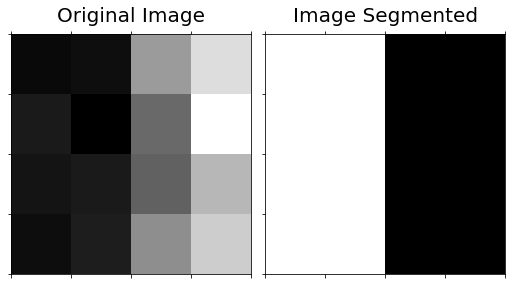

KeyboardInterrupt: ignored

In [ ]:
import pandas as pd

results = main()
results_df = pd.DataFrame(results)
results_df.to_excel("Results_Quantum_Spectral_Clustering.xlsx") 

In [ ]:
results_df

,0,1,2
0,0.050436,0.051213,0.000488


In [ ]:
def estimate_cost(graph, samples):
    """Estimate the cost function of the QAOA on the given graph using the
    provided computational basis bitstrings."""
    cost_value = 0.0

    # Loop over edge pairs and compute contribution.
    for u, v, w in graph.edges(data=True):
        u_samples = samples[str(u)]
        v_samples = samples[str(v)]

        # Determine if it was a +1 or -1 eigenvalue.
        u_signs = (-1)**u_samples
        v_signs = (-1)**v_samples
        term_signs = u_signs * v_signs

        # Add scaled term to total cost.
        term_val = np.mean(term_signs) * w['weight']
        cost_value += term_val

    return -cost_value